# Blackbox Optimization

## 概要

このチュートリアルでは、JijZept Toolsを使ってブラックボックス最適化を実行する方法を紹介します。
ブラックボックス最適化は、関数の詳細な情報を持たずに最適化を行う手法です。ブラックボックス最適化は、様々な分野で利用されており、材料探索やハイパーパラメータ最適化などの問題に適用されています。
このチュートリアルでは

- FMO (Factorization Machine Optimization)
- BOCS (Bayesian Optimization for Combinatorial Structures)

の2つのブラックボックス最適化手法を紹介します。

では早速、ブラックボックス最適化を試す準備をしていきましょう。

## ブラックボックス関数の用意

まずは、ブラックボックス関数を用意します。ここでは簡単な関数として
$$
\min_x x Q x^T,~x \in \{0, 1\}^n
$$
のようなQUBOを考えます。

In [1]:
import numpy as np


class QuadraticBlackboxFunc:
    def __init__(self, n: int, random_seed: int = 0):
        self.random_state = np.random.RandomState(random_seed)
        Q = self.random_state.uniform(-0.5, 1, (n, n))
        self.Q = (Q + Q.T) / 2
        self.Q[np.abs(self.Q) < 0.08] = 0.0

        noise_variance = 0.1
        num_vars = n
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(random_seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars))

    def __call__(self, x: np.ndarray) -> float:
        return x @ self.Q @ x

### 初期データの用意

ブラックボックス最適化を行うために初期データを用意しておきましょう。必ずしも初期データが必要なわけではありませんが、初期データを用意することで収束を早めることができます。

ここでは、ランダムに初期データを生成します。

In [2]:
n = 30
num_init = 10

quad_bf = QuadraticBlackboxFunc(n)

X_init = np.random.choice([0, 1], (num_init, n))
y_init = np.array([quad_bf(x) for x in X_init])

## 最適化ソルバーを用意

このチュートリアルで紹介するFMOとBOCSの2つは代理関数としてQUBO行列を生成し、そのQUBO行列を解くことで最適化を行います。そのため、QUBOソルバーを用意する必要があります。ここではOpenJijを用いてQUBOソルバーを用意します。

また今回はブラックボックス関数としてQUBOを用いているため、そのQUBOを直接解くことができます。それぞれのブラックボックス関数の性能を比較するために直接解いておいてその結果を `estimated_ground` に格納しておきます。

In [3]:
import openjij as oj


def solver(Q):
    _Q, _ = Q
    sampler = oj.SASampler()
    response = sampler.sample_qubo(_Q, num_reads=100)
    return response.lowest().states[0]


estimated_ground = quad_bf(solver((quad_bf.Q, None)))

## Factorization Machine Optimization

このセクションでは、Factorization Machine Optimization (FMO) と呼ばれるブラックボックス最適化手法をJijZept Toolsを使って利用する方法を紹介します。

FMOは、{cite}`fmqa` によって提案され、材料探索やハイパーパラメータ最適化などの様々な問題に適用されその有効性が示されています。また元の提案では量子アニーリングやシミュレーテッドアニーリングを用いて最適化を行われていたので、FMQA (FM Quantum Annealing) や FMA (FM Annealing) と呼ばれることが多いです。JijZept Toolsでは最適化の部分に別のアルゴリズムを適用することも可能なので、ここでは FMO と呼ぶことにします。

FMO は、Factorization Machine (FM) と呼ばれる機械学習モデルを用いて、ブラックボックス関数の代理関数を構築し、その代理関数としてのFMをQUBO形式に変換して最適化を行う方法です。ガウス過程などを用いた手法と比較して、FMO は高次元の変数や離散変数に対して有用であることが知られています。

早速、FMOを使って最適化を行ってみましょう。まずは`FMOWorkflow`をimportします。

In [4]:
from jijzepttools.blackbox_optimization import FMOWorkflow

FMOWorkflowは内部でJijZept Toolsのworkflow graphを用いて実装されているため、Jupyter Notebook上でどのようなワークフローが組まれているのかを `.workflow.display_workflow()` を利用して可視化することができます。



`FMOWorkflow`クラスのコンストラクタの引数にある `n_iter` は、最適化の反復回数を指定します。`n_iter` が大きいほど、最適化の反復回数が増えるため、最適化の精度が向上しますが、計算時間が増加します。

また、`FMOWorkflow`クラスのコンストラクタの引数にある `latent_dim` は、FMの次元を指定します。`latent_dim` が大きいほど、FMの次元が増えるため、FMの表現力が向上しますが、過学習のリスクが高まります。

`FMOWorkflow`クラスのコンストラクタの引数にある `flip_postprocess4uniq`フラグは、最適化結果の後処理を行うかどうかを指定します。このフラグを `True` にすることで、最適化結果の後処理を行うことができます。後処理を行うことで、最適化結果の重複を除去することができます。後処理を行わない場合、最適化結果に重複が含まれる可能性があります。FMOは局所解に陥りやすいため、後処理を行うことで局所解に入っても抜け出して学習を進めかつ、より大域的な最適化を行うことができます。
`flip_postprocess4uniq` フラグを立てるとworkflowで`solve`の後に`flip_post_process`という処理が入っていることがわかるかと思います。
実際に `flip_postprocess4uniq` フラグを切り替えてみてWorkflowが変わることを確認してみてください。

In [5]:
fmo_wf = FMOWorkflow(n, latent_dim=5, flip_postprocess4uniq=True)
fmo_wf.workflow.display_workflow("LR")

```mermaid
graph LR;
    _START_["_START_"]
    _START_ --> train
    _END_["_END_"]
    train["train"]
    train --> generate_qubo
    generate_qubo["generate_qubo"]
    generate_qubo --> solve
    solve["solve"]
    solve --> flip_post_process
    flip_post_process["flip_post_process"]
    flip_post_process --> run_blackbox
    run_blackbox["run_blackbox"]
    run_blackbox --> check_iter
    check_iter["check_iter"]
    check_iter -->|"True"| train
    check_iter -->|"False"| _END_
```

![FMO](./assets/FMO_Workflow.png)

### FMOの実行

それでは、FMOを実行してみましょう。`.run()` メソッドを呼び出すことで、最適化を実行することができます。ここで第三引数にブラックボックス関数を指定します。内部でブラックボックス関数を呼び出しながら最適化を行います。

In [6]:
fmo_results = fmo_wf.run(
    X_init,
    y_init,
    quad_bf,
    solver,
    n_iter=50,
    n_epochs=100,
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

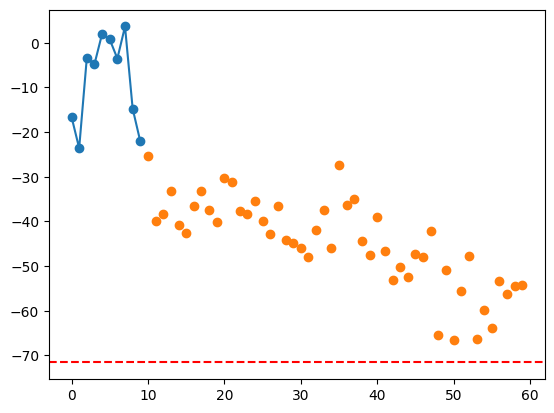

In [7]:
import matplotlib.pyplot as plt

plt.plot(fmo_results[1][:num_init], "-o")
plt.plot(np.arange(num_init, len(fmo_results[1])), fmo_results[1][num_init:], "o")
plt.axhline(estimated_ground, color="red", linestyle="--")

## Bayesian Optimization for Combinatorial Structures

このセクションでは、Bayesian Optimization for Combinatorial Structures (BOCS) と呼ばれるブラックボックス最適化手法をJijZept Toolsを使って利用する方法を紹介します。

BOCSは、{cite}`bocs` によって提案され、組合せ最適化問題に対して有効であることが知られています。BOCSは、ブラックボックス関数の代理関数を獲得する方法としてベイズスパース線形回帰を用いて最適化を行う手法です。スパース線形回帰を行うために事前分布として馬蹄分布を用いています。JijZept Toolsではギブスサンプリングを用いて事後分布を推定しています。

JijZept Toolsを用いることでややこしい実装を気にすることなくBOCSを利用することができます。
では早速FMOの時と同様の方法でBOCSを実行してみましょう。

FMOと同様に、`BOCSWorkflow`をimportします。BOCSWorkflowでもpostprocessをオンにできますが、BOCSはFMOに比べて局所解に陥りにくいため、postprocessをオンにする必要はありません。

あとはFMOの時と同様に利用することができます。

In [8]:
from jijzepttools.blackbox_optimization import BOCSWorkflow

bocs_wf = BOCSWorkflow()
bocs_wf.workflow.display_workflow("LR")

```mermaid
graph LR;
    _START_["_START_"]
    _START_ --> train
    _END_["_END_"]
    train["train"]
    train --> generate_qubo
    generate_qubo["generate_qubo"]
    generate_qubo --> solve
    solve["solve"]
    solve --> run_blackbox
    run_blackbox["run_blackbox"]
    run_blackbox --> check_iter
    check_iter["check_iter"]
    check_iter -->|"True"| train
    check_iter -->|"False"| _END_
```

In [9]:
bocs_results = bocs_wf.run(X_init, y_init, quad_bf, solver, n_iter=50, tune=1, draws=1)

  0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

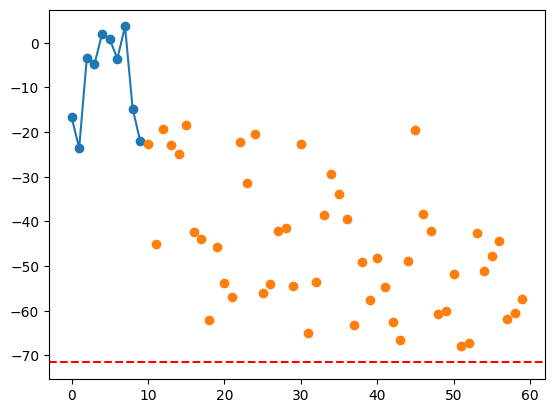

In [10]:
import matplotlib.pyplot as plt

plt.plot(bocs_results[1][:num_init], "-o")
plt.plot(np.arange(num_init, len(bocs_results[1])), bocs_results[1][num_init:], "o")
plt.axhline(estimated_ground, color="red", linestyle="--")